# Successor Representation Learning Experiments

Referenced Work: [Stachenfeld et al., 2017](https://www.nature.com/articles/nn.4650).

This notebook demonstrates how to generate value maps, successor matrix maps (place-like cells), and successor matrix eigendecomposition maps (grid-like cells) from an agent trained using a successor representation.

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [2]:
from neuronav.envs.grid_env import GridEnv, GridSize
from neuronav.agents.td_agents import TDSR
from neuronav.envs.grid_topographies import GridTopography
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

### Loading the environment

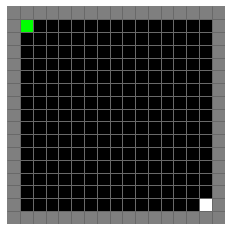

In [3]:
env = GridEnv(topography=GridTopography.empty, grid_size=GridSize.large)
obs = env.reset()
env.render()

### Visualizing the agent's value function

We plot both the `Q(s, a)` values for each of the four actions (blue) as well as the `V(s)` values (green).

In [4]:
num_episodes = 1000
num_steps = 100

agent = TDSR(
    env.state_size, env.action_space.n, lr=1e-1, poltype="egreedy", epsilon=0.2
)

for _ in range(num_episodes):
    agent, _, _ = run_episode(env, agent, num_steps, random_start=True)

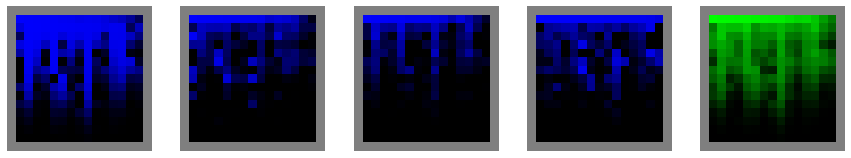

In [5]:
y = 5

fig, axs = plt.subplots(1, y, figsize=(y * 3, 3))

for j in range(y):
    axs[j].axis("off")
    b = env.grid(render_objects=False)
    if j < y - 1:
        a = agent.Q[j].reshape(env.grid_size, env.grid_size)
        b[:, :, 2] += np.clip(np.sqrt(a), 0, 1)
    else:
        a = np.mean(agent.Q, axis=0).reshape(env.grid_size, env.grid_size)
        b[:, :, 1] += np.clip(np.sqrt(a), 0, 1)
    axs[j].imshow(b)

### Analyzing the successor representation

In [6]:
agent = TDSR(
    env.state_size,
    env.action_space.n,
    lr=1e-1,
    poltype="egreedy",
    epsilon=1.0,
    goal_biased_sr=False,
)
num_episodes = 1000
num_steps = 100

for i in range(num_episodes):
    agent, _, _ = run_episode(env, agent, num_steps, random_start=True, reward_locs={})

m_map = {}
for state in range(env.state_size):
    if agent.M[:, state].mean(0).sum() != 1:
        m_map[state] = agent.M.mean(0)[state]
m_map = np.stack(list(m_map.values()))

#### Visualizing the agent's successor matrix "place cells"

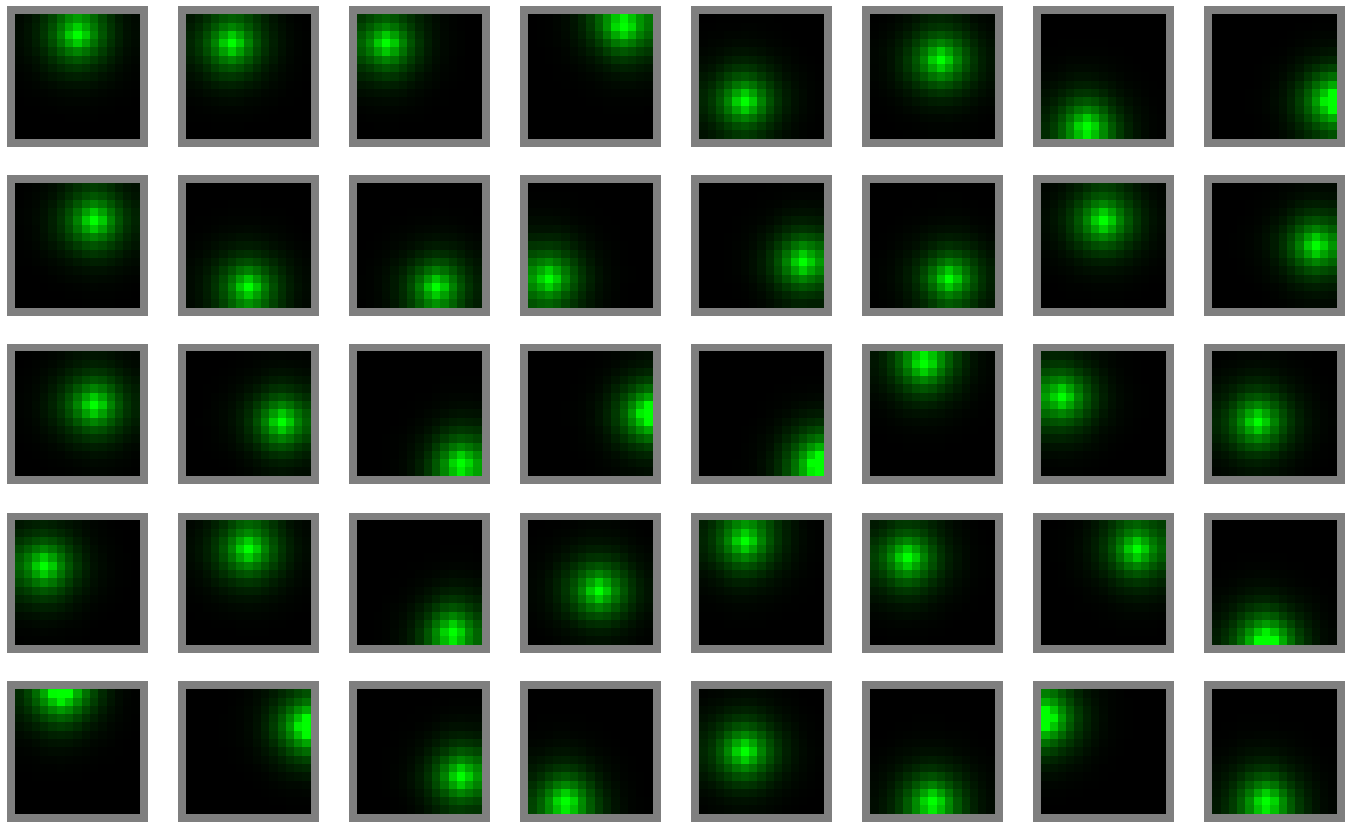

In [7]:
def plot_sr_maps(m_map, map_x=8, map_y=5):
    x, y = map_x, map_y

    fig, axs = plt.subplots(y, x, figsize=(x * 3, y * 3))

    np.random.shuffle(m_map)

    for i in range(x):
        for j in range(y):
            axs[j, i].axis("off")
            a = m_map[i * y + j].reshape(env.grid_size, env.grid_size)
            b = env.grid(render_objects=False)
            b[:, :, 1] += np.clip(np.power(a, 0.5), 0, 1)
            axs[j, i].imshow(b)


plot_sr_maps(m_map, 8, 5)

#### Visualizing the agent's successor matrix "grid cells"

These are generated using PCA on the successor map, as done in [Stachenfeld et al., 2017](https://www.nature.com/articles/nn.4650).

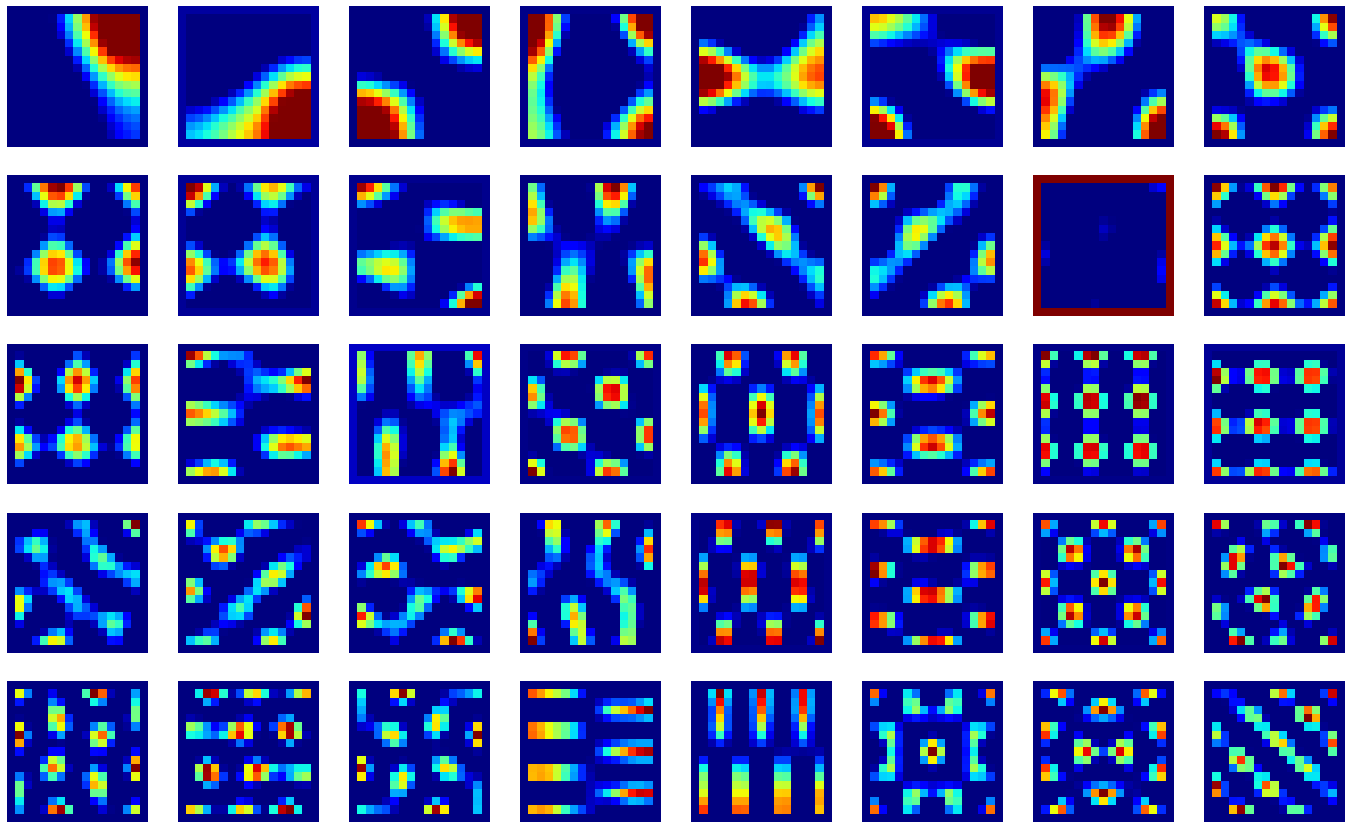

In [8]:
y = 8
x = 5

mean_m = np.mean(agent.M, axis=0)
pca = PCA(n_components=y * x, svd_solver="full")
result = pca.fit_transform(mean_m.T)
result = np.clip(result, 0, 1)

fig, axs = plt.subplots(x, y, figsize=(y * 3, x * 3))

for j in range(x):
    for i in range(y):
        axs[j, i].axis("off")
        axs[j, i].imshow(
            result[:, (i + (j * y))].reshape(env.grid_size, env.grid_size), cmap="jet"
        )

#### Obstacles distort successor "place cell" maps

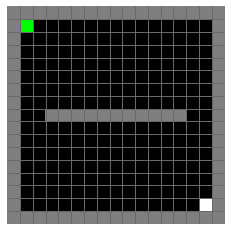

In [9]:
env = GridEnv(topography=GridTopography.obstacle, grid_size=GridSize.large)
obs = env.reset()
env.render()

agent = TDSR(
    env.state_size,
    env.action_space.n,
    lr=1e-1,
    poltype="egreedy",
    epsilon=1.0,
    goal_biased_sr=False,
)
num_episodes = 1000
num_steps = 100

for i in range(num_episodes):
    agent, _, _ = run_episode(env, agent, num_steps, random_start=True, reward_locs={})

m_map = {}
for state in range(env.state_size):
    if agent.M[:, state].mean(0).sum() != 1:
        m_map[state] = agent.M.mean(0)[state]
m_map = np.stack(list(m_map.values()))

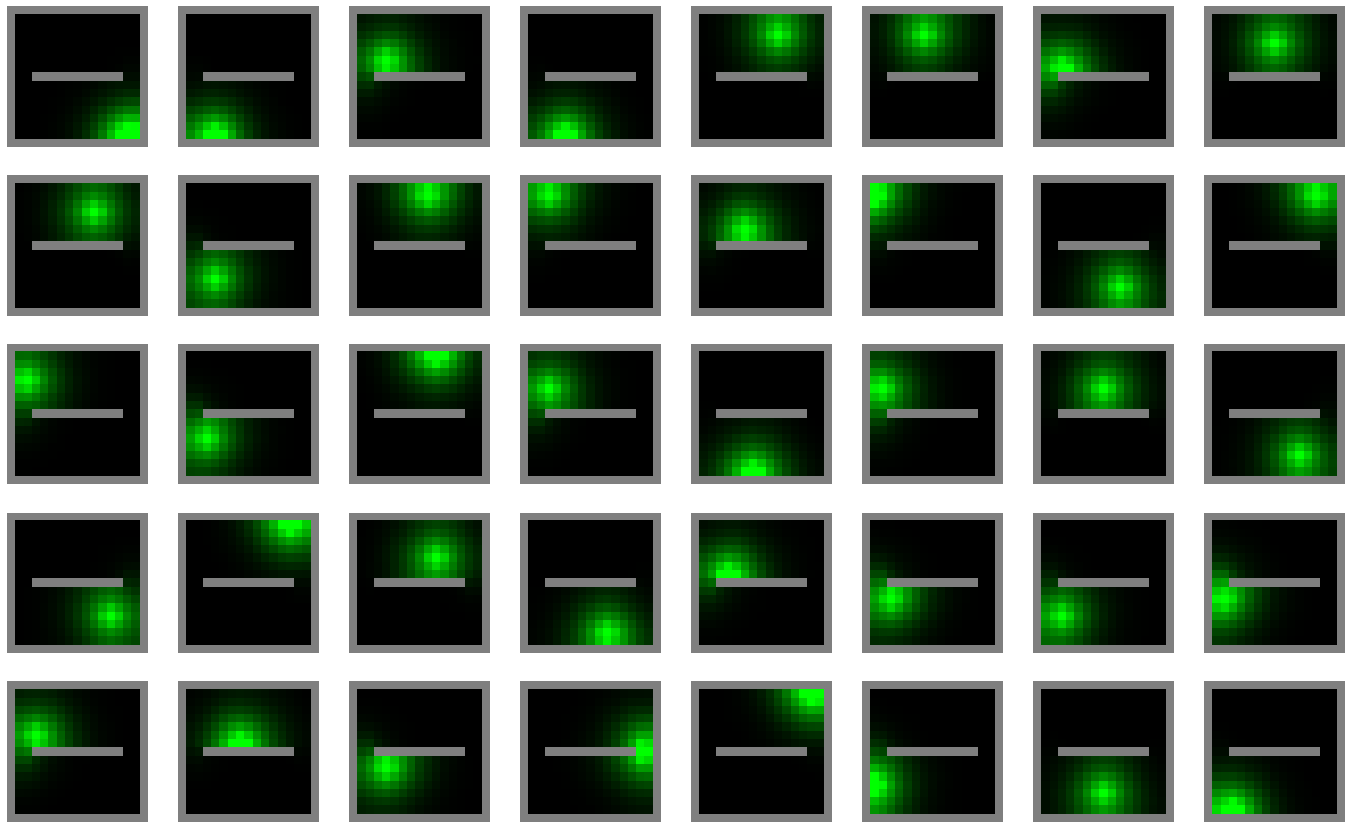

In [10]:
plot_sr_maps(m_map)